# 1. Importing, exploring and cleaning ISEAR dataset

In [5]:
!git clone https://github.com/Bhattars1/MSc-Project-Expression-Recognition-

Cloning into 'MSc-Project-Expression-Recognition-'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 99 (delta 35), reused 34 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (99/99), 40.95 MiB | 14.55 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [6]:
# Import function for goemotion dataset
import pandas as pd
def upload_go(path):
  df = pd.read_csv(path)
  return df

In [7]:
go_path_1 ="/content/MSc-Project-Expression-Recognition-/geoemotion dataset/goemotions_1.csv"
go_path_2 ="/content/MSc-Project-Expression-Recognition-/geoemotion dataset/goemotions_2.csv"
go_path_3 ="/content/MSc-Project-Expression-Recognition-/geoemotion dataset/goemotions_3.csv"

go_v1 = upload_go(go_path_1)
go_v2 = upload_go(go_path_2)
go_v3 = upload_go(go_path_3)

In [8]:
selected_columns = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral"
]

In [9]:
emotions_columns = ["text", "anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

In [10]:
def clean_geo(data, columns, text_column, emotions_columns):
    # Select relevant columns from the data
    df = data[columns].copy()  # Ensure we are working with a copy to avoid SettingWithCopyWarning

    # Convert one-hot encoded columns to a single column of emotion labels
    df['emotion'] = df[columns].idxmax(axis=1)

    # Drop the one-hot encoded emotion columns
    df = df.drop(columns=columns)

    # Add a new column named 'text' with data from data[text_column]
    df['text'] = data[text_column].values  # Use .values to avoid SettingWithCopyWarning

    # Filter to keep only rows where 'emotion' matches one of the specified emotions
    df = df[df['emotion'].isin(emotions_columns)].copy()  # Ensure we are working with a copy

    return df


In [11]:
cleaned_go_1 = clean_geo(go_v1, selected_columns, "text", emotions_columns)
cleaned_go_2 = clean_geo(go_v2, selected_columns, "text", emotions_columns)
cleaned_go_3 = clean_geo(go_v3, selected_columns, "text", emotions_columns)

In [12]:
# Concatenate DataFrames vertically
combined_df = pd.concat([cleaned_go_1, cleaned_go_2, cleaned_go_3], ignore_index=True)

In [13]:
def data_labels(df, data, labels):
  data = df[data].tolist()
  labels = df[labels].tolist()
  return data, labels

In [14]:
final_df, final_labels = data_labels(combined_df, "text", "emotion")
len(final_df), len(final_labels)

(81643, 81643)

In [15]:
# Checking if the dataset is balanced or not
def label_distribution(data):
  dict_labels = {}
  unique_expressions = list(set(data))
  for idx, i in enumerate(unique_expressions):
    dict_labels[i] = list(data).count(i)
  return dict_labels
label_distribution(final_labels)

{'joy': 5120,
 'fear': 2514,
 'disgust': 3420,
 'neutral': 55298,
 'surprise': 3472,
 'sadness': 3863,
 'anger': 7956}

In [16]:
# Balancing the data
import random

# Separate the neutral and anger samples
neutral_indices = [i for i, label in enumerate(final_labels) if label == 'neutral']
anger_indices = [i for i, label in enumerate(final_labels) if label == 'anger']
other_indices = [i for i, label in enumerate(final_labels) if label != 'neutral' and label != 'anger']

# Randomly sample 5000 neutral and anger indices
sampled_neutral_indices = random.sample(neutral_indices, 5000 )
sampled_anger_indices = random.sample(anger_indices, 5000)

# Combine the non-neutral indices with the sampled neutral indices
balanced_indices =other_indices + sampled_neutral_indices + sampled_anger_indices

# Create the balanced labels and data lists
balanced_labels = [final_labels[i] for i in balanced_indices]
balanced_data = [final_df[i] for i in balanced_indices]

In [17]:
dist = label_distribution(balanced_labels)
dist

{'joy': 5120,
 'fear': 2514,
 'disgust': 3420,
 'neutral': 5000,
 'surprise': 3472,
 'sadness': 3863,
 'anger': 5000}

# 2. Preprocessing

## 2.1. Data Augmentation

Augmenting the data that is not sufficient i.e. all the data that corresponds to the labels except neutral and anger. Hera a special technique is used i.e. translating the insufficient data to german and again to english that can introduce variability while preserving meaning.

Example: English → German → English: "The cat is on the mat" → "The cat lies on the mat."

In [29]:
# Checking and specifiying what and how much to augument to perfectly balance the data
augument_list = [x for x in dist if dist[x] < 5000]
augumenting_dict = {}
for i in augument_list:
  x = dist[i]
  augumenting_dict[i] = 5000-x
augumenting_dict

{'disgust': 1580, 'sadness': 1137, 'surprise': 1528, 'fear': 2486}

In [30]:
# Randomly selecting the data from specific labels to augument
fear_indices = [i for i, label in enumerate(balanced_labels) if label == 'fear']
sadness_indices = [i for i, label in enumerate(balanced_labels) if label == 'sadness']
surprise_indices = [i for i, label in enumerate(balanced_labels) if label == 'surprise']
disgust_indices = [i for i, label in enumerate(balanced_labels) if label == 'disgust']

In [31]:
# Randomly sample indices
sampled_fear_indices = random.sample(fear_indices, augumenting_dict["fear"])
sampled_sadness_indices = random.sample(sadness_indices, augumenting_dict["sadness"])
sampled_surprise_indices = random.sample(surprise_indices, augumenting_dict["surprise"])
sampled_disgust_indices = random.sample(disgust_indices, augumenting_dict["disgust"])

In [32]:
# Data that corresponds to the indices
sampled_fear_data = [balanced_data[i] for i in sampled_fear_indices]
sampled_sadness_data = [balanced_data[i] for i in sampled_sadness_indices]
sampled_surprise_data = [balanced_data[i] for i in sampled_surprise_indices]
sampled_disgust_data = [balanced_data[i] for i in sampled_disgust_indices]

In [21]:
!pip install googletrans-py
from googletrans import Translator
import time

# Initialize the translator
translator = Translator()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00
  Created wheel for googletrans-py: filename=googletrans_py-4.0.0-py3-none-any.whl size=13116 sha256=5e381cf2b146477f1b63bdda33354ad88d15d2f196c18c5c3629faf5f9953a8e
  Stored in directory: /root/.cache/pip/wheels/5b/a3/b4/1d34a1edaec73dfb935c8a01c9430b80cf68236dbcaf54df53
Successfully built googletrans-py


In [22]:
def translating_back(text, src_lang='en', tgt_lang='de'):
    try:
        # Translate to german
        translated_text = translator.translate(text, src=src_lang, dest=tgt_lang).text
        # Translate text back english
        back_translated_text = translator.translate(translated_text, src=tgt_lang, dest=src_lang).text
        return back_translated_text
    except Exception:
        # Return None if there is an error
        return None

In [24]:
sample_text = "The elaborate mechanism malfunctioned unexpectedly, complicating the team's delicate operation."
translating_back(sample_text)

"The detailed mechanism was unexpectedly lacking and makes it difficult for the team's sensitive operation."

In [25]:
# translating function
import tqdm
def trans_func(data, batch_size=32):
    translated_data = []
    failed_count = 0

    for i in tqdm.tqdm(range(0, len(data), batch_size), desc="Translating"):
        batch = data[i:i + batch_size]
        batch_translated = []

        for text in batch:
            try:
                # Translate text and handle potential errors
                translated_text = translating_back(text)
                if translated_text is not None:
                    batch_translated.append(translated_text)
                else:
                    failed_count += 1
            except Exception:

                failed_count += 1

        translated_data.extend(batch_translated)

    print(f"Number of failed translations: {failed_count}")
    return translated_data

In [33]:
augmented_fear_data = trans_func(sampled_fear_data)
augmented_sadness_data = trans_func(sampled_sadness_data)
augmented_surprise_data = trans_func(sampled_surprise_data)
augmented_disgust_data = trans_func(sampled_disgust_data)

Translating: 100%|██████████| 78/78 [38:50<00:00, 29.88s/it]


Number of failed translations: 153


Translating: 100%|██████████| 36/36 [25:04<00:00, 41.80s/it]


Number of failed translations: 26


Translating: 100%|██████████| 48/48 [34:07<00:00, 42.67s/it]


Number of failed translations: 0


Translating: 100%|██████████| 50/50 [34:00<00:00, 40.80s/it]

Number of failed translations: 1


In [42]:
# Checkout the augmented data
checklist = [augmented_fear_data, augmented_sadness_data, augmented_surprise_data, augmented_disgust_data]
for i in checklist:
  print(f"\n")
  for idx, j in enumerate(i):
    print(j)
    if idx == 5:
      break



This seems to say that unless something has been lost in the translation
Bossian spirit! Leave this place and never return !!
This opening is pretty terrible TBH
I literally screamed uncontrolled for 3 months and landed in a psychiatric hospital.
In fact that was terrifying, but why does he wear a mask?!?!?!
Watch the left arm and hand as it is on the floor.


Pet-Sitting is over, I didn't know that I was lonely without dogs until now.
It makes me sad that the legacy [name] has become "posterboy for angular maniacs".
Damn as a mother of boys who let me upset directly
What kind of PC Cuck
"Yeeaah, I know that you are homeless and everyone except apartments are really boring. My most beautiful memories were all made outside in nature."
Wow, that's a fairly depressing article. I agree with points, but more slowly with the downfall and darkness.


Ooooooo ... Yikes
Wow, you never have to have been to / or like dozens of anti [names] -subreddits.
Oh my gooooooooood
And yet nobody beat an 

In [51]:
# Combine augmented data
augmented_data = (augmented_fear_data + augmented_sadness_data +
                  augmented_surprise_data + augmented_disgust_data)
# Combine augmented labels
augmented_fear_labels = ['fear'] * len(augmented_fear_data)
augmented_sadness_labels = ['sadness'] * len(augmented_sadness_data)
augmented_surprise_labels = ['surprise'] * len(augmented_surprise_data)
augmented_disgust_labels = ['disgust'] * len(augmented_disgust_data)

augmented_labels = (augmented_fear_labels + augmented_sadness_labels +
                    augmented_surprise_labels + augmented_disgust_labels)

# Assuming `balanced_data` and `balanced_labels` are your existing lists
balanced_data.extend(augmented_data)
balanced_labels.extend(augmented_labels)

In [52]:
label_distribution(balanced_labels), len(balanced_data), len(balanced_labels)

({'disgust': 4999,
  'neutral': 5000,
  'joy': 5120,
  'sadness': 4974,
  'surprise': 5000,
  'fear': 4847,
  'anger': 5000},
 34940,
 34940)

## 2.2. Embedding using BERT

In [25]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [26]:
# Embedding function
import tqdm
def generate_bert_embeddings(sentences, batch_size=4):
    embeddings_list = []
    for i in tqdm.tqdm(range(0, len(sentences), batch_size), desc="Generating BERT embeddings"):
        batch = sentences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Extract embeddings of the [CLS] token (index 0) for each sentence
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings_list.append(cls_embeddings)
    embeddings = torch.cat(embeddings_list)
    return embeddings

In [59]:
data_embeddings = generate_bert_embeddings(balanced_data)

Generating BERT embeddings: 100%|██████████| 8735/8735 [1:04:45<00:00,  2.25it/s]


In [60]:
# Save embeddings
torch.save(data_embeddings, 'data_embeddings.pt')

In [19]:
# Load embeddings
import torch
loaded_embeddings = torch.load('data_embeddings.pt')
# final_labels = torch.load("labels.pt")

# Verify loaded embeddings
len(loaded_embeddings)

<ipython-input-19-cd033539d5c6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_embeddings = torch.load('data_embeddings.pt')


34940

Indexing labels

In [20]:
unique_labels = list(set(balanced_labels))
unique_labels

['joy', 'fear', 'disgust', 'neutral', 'surprise', 'sadness', 'anger']

In [21]:
itol = {}
ltoi = {}
for i, label in enumerate(unique_labels):
  itol[i]= label
  ltoi[label] = i
print(itol)
print(ltoi)

{0: 'joy', 1: 'fear', 2: 'disgust', 3: 'neutral', 4: 'surprise', 5: 'sadness', 6: 'anger'}
{'joy': 0, 'fear': 1, 'disgust': 2, 'neutral': 3, 'surprise': 4, 'sadness': 5, 'anger': 6}


In [22]:
# Convert label list to index list
index_labels = [ltoi[label] for label in balanced_labels]
index_labels[:5]

[5, 2, 0, 0, 0]

In [23]:
labels_tensor = torch.tensor(index_labels)
torch.save(labels_tensor, 'labels.pt')
len(index_labels)

28389

In [27]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute cosine similarity between two sentences
def compute_similarity(embedding1, embedding2):
    # Convert tensors to numpy arrays
    embedding1 = embedding1.numpy()
    embedding2 = embedding2.numpy()
    # Compute cosine similarity
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]

# Example sentences
sentence1 = "That was a great experience playing badminton."
sentence2 = "I will love to play it again."

# Process the sentences
processed_sentences = [sentence1, sentence2]


# Generate BERT embeddings
embeddings = generate_bert_embeddings(processed_sentences)

# Extract embeddings for the sentences
embedding1 = embeddings[0:1]  # First sentence
embedding2 = embeddings[1:2]  # Second sentence

# Compute similarity
similarity_score = compute_similarity(embedding1, embedding2)

print(f"Similarity score between the sentences: {similarity_score}")

Generating BERT embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

Similarity score between the sentences: 0.9205251932144165


In [28]:
labels_tensor = torch.load("labels.pt")
loaded_embeddings = torch.load("data_embeddings.pt")

<ipython-input-28-dc93b6961812>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels_tensor = torch.load("labels.pt")
<ipython-input-28-dc93b6961812>:2: FutureWarning: Yo

In [29]:
loaded_embeddings = loaded_embeddings.float()

In [30]:
len(loaded_embeddings), len(labels_tensor)

(34940, 34940)

# 3. Prepare the data

In [31]:
# Split the dataset
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split


dataset = TensorDataset(loaded_embeddings, labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 4. Developing Neural Network and training

In [32]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

## 4.1. Hyperparemeter optimization using randomsearchCV

In [72]:
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

class PyTorchLSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, output_dim=7, lr=0.001, batch_size=16, epochs=10):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers).to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def fit(self, X, y):
        self.model.train()
        train_loader = DataLoader(dataset=list(zip(X, y)), batch_size=self.batch_size, shuffle=True)
        for epoch in range(self.epochs):
            for data, target in train_loader:
                data, target = data.to(self.device), target.to(self.device)
                data = data.unsqueeze(1)  # Add sequence dimension
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()

    def predict(self, X):
        self.model.eval()
        test_loader = DataLoader(dataset=X, batch_size=self.batch_size, shuffle=False)
        predictions = []
        with torch.no_grad():
            for data in test_loader:
                data = data.to(self.device)
                data = data.unsqueeze(1)  # Add sequence dimension
                output = self.model(data)
                _, predicted = torch.max(output, 1)
                predictions.extend(predicted.cpu().numpy())
        return np.array(predictions)

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

In [73]:
# Convert datasets to lists of tensors for sklearn compatibility
X_train = [data[0] for data in train_dataset]
y_train = [data[1].item() for data in train_dataset]

In [74]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'hidden_dim': [64, 128, 256],
    'num_layers': [1, 2, 3],
    'lr': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [10, 20, 30]
}

# Instantiate the classifier
pytorch_lstm_clf = PyTorchLSTMClassifier(input_dim=loaded_embeddings.size(1), output_dim=7)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(pytorch_lstm_clf, param_distributions=param_dist, n_iter=5, cv=2, verbose=2, n_jobs=1)
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END batch_size=16, epochs=10, hidden_dim=64, lr=0.01, num_layers=3; total time= 2.3min
[CV] END batch_size=16, epochs=10, hidden_dim=64, lr=0.01, num_layers=3; total time= 2.3min
[CV] END batch_size=32, epochs=30, hidden_dim=256, lr=0.001, num_layers=3; total time= 3.9min
[CV] END batch_size=32, epochs=30, hidden_dim=256, lr=0.001, num_layers=3; total time= 3.9min
[CV] END batch_size=16, epochs=20, hidden_dim=256, lr=0.0001, num_layers=1; total time= 4.7min
[CV] END batch_size=16, epochs=20, hidden_dim=256, lr=0.0001, num_layers=1; total time= 4.7min
[CV] END batch_size=16, epochs=20, hidden_dim=256, lr=0.001, num_layers=3; total time= 4.7min
[CV] END batch_size=16, epochs=20, hidden_dim=256, lr=0.001, num_layers=3; total time= 4.7min
[CV] END batch_size=16, epochs=10, hidden_dim=128, lr=0.01, num_layers=2; total time= 2.4min
[CV] END batch_size=16, epochs=10, hidden_dim=128, lr=0.01, num_layers=2; total time= 2.6min
Best

In [32]:
# Extracting the best parameters from the random search
best_params = random_search.best_params_

# Defining variables for each parameter
LR = best_params['lr']
BATCH_SIZE = best_params['batch_size']
EPOCHS = best_params['epochs']
HIDDEN_DIM = best_params['hidden_dim']
NUM_LAYERS = best_params['num_layers']

In [33]:
BATCH_SIZE = 16
EPOCHS = 10
HIDDEN_DIM = 128
NUM_LAYERS = 2
LR = 0.01

In [34]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [35]:
# Setting up parameters
input_dim = loaded_embeddings.size(1)
hidden_dim = HIDDEN_DIM
output_dim = 7
num_layers = NUM_LAYERS

model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 4.2. Training loop

In [36]:
# Set up learning rate scheduler for decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# DEfining training loop
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=EPOCHS):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0

        # Manually adjust the learning rate for the last 5 epochs
        if epoch >= num_epochs - 5:
            for param_group in optimizer.param_groups:
                param_group['lr'] = LR / 10

        for batch in train_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)
            embeddings = embeddings.unsqueeze(1)  # Add sequence dimension
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

train_model(model, train_loader, criterion, optimizer, device, num_epochs=EPOCHS+5)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)
            embeddings = embeddings.unsqueeze(1)  # Add sequence dimension
            outputs = model(embeddings)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

evaluate_model(model, test_loader, device)

Epoch [1/15], Loss: 1.6695
Epoch [2/15], Loss: 1.5608
Epoch [3/15], Loss: 1.5403
Epoch [4/15], Loss: 1.5248
Epoch [5/15], Loss: 1.5116
Epoch [6/15], Loss: 1.4949
Epoch [7/15], Loss: 1.4870
Epoch [8/15], Loss: 1.4778
Epoch [9/15], Loss: 1.4625
Epoch [10/15], Loss: 1.4433
Epoch [11/15], Loss: 1.3777
Epoch [12/15], Loss: 1.3578
Epoch [13/15], Loss: 1.3481
Epoch [14/15], Loss: 1.3376
Epoch [15/15], Loss: 1.3297
Test Accuracy: 0.4788


In [36]:
model_path = "lstm_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [36]:
model.load_state_dict(torch.load(model_path))
model.to(device)

# 5. Evaluation using Confusion Matrix

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

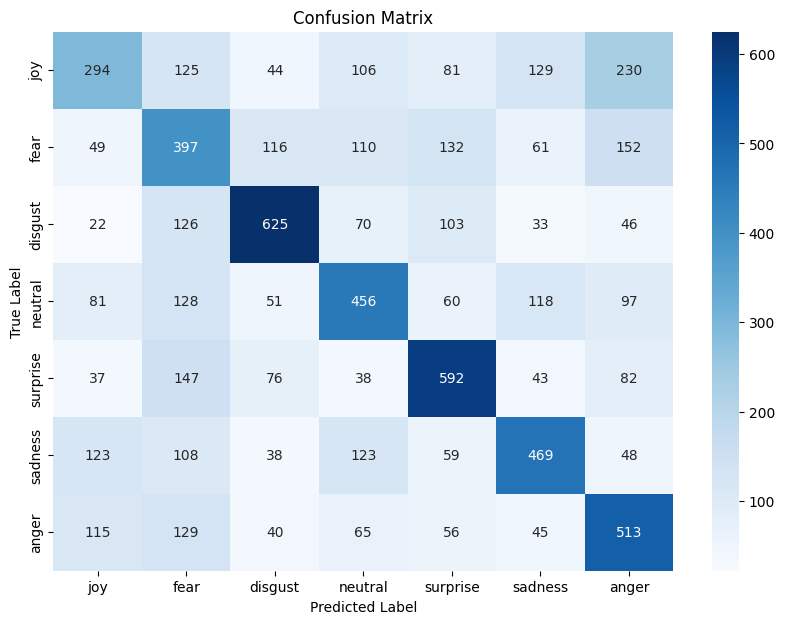

In [38]:
def plot_confusion_matrix(model, data_loader, device, label_dict):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in data_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)
            embeddings = embeddings.unsqueeze(1)
            outputs = model(embeddings)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    num_classes = len(label_dict)
    cm = confusion_matrix(all_labels, all_predictions, labels=list(label_dict.keys()))

    # Create a list of class names for plotting
    class_names = [label_dict[i] for i in range(num_classes)]

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader, device, itol)